## For development of scripts. To be deleted.

### training_curves.py

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [183]:
models_path = '../models'

# make a list of all folders in models_path
import os
folders = [f for f in os.listdir(models_path) if os.path.isdir(os.path.join(models_path, f))]
folders

['run32_test_torch', 'run4_lr3e5', 'run4_lr4e5']

In [185]:
# load log_history
with open('../models/run4_lr3e-5/log_history', 'rb') as f:
    log_history = pickle.load(f)

In [187]:
log_history[1]

[{'Training Loss': 1.1635,
  'Epoch': 1.0,
  'Step': 185,
  'Validation Loss': 0.746825635433197,
  'Coherence Rmse': 0.7939225435256958,
  'Empathy Rmse': 0.6873879432678223,
  'Surprise Rmse': 0.7220385074615479,
  'Engagement Rmse': 0.7613773345947266,
  'Complexity Rmse': 0.7647821307182312,
  'Mcrmse': 0.7459017038345337},
 {'Training Loss': 0.6737,
  'Epoch': 2.0,
  'Step': 370,
  'Validation Loss': 0.7210269570350647,
  'Coherence Rmse': 0.756166398525238,
  'Empathy Rmse': 0.693126916885376,
  'Surprise Rmse': 0.704208254814148,
  'Engagement Rmse': 0.7160723805427551,
  'Complexity Rmse': 0.7338378429412842,
  'Mcrmse': 0.7206823229789734},
 {'Training Loss': 0.6527,
  'Epoch': 3.0,
  'Step': 555,
  'Validation Loss': 0.7150335311889648,
  'Coherence Rmse': 0.7529668807983398,
  'Empathy Rmse': 0.6936216950416565,
  'Surprise Rmse': 0.6986141204833984,
  'Engagement Rmse': 0.7086846828460693,
  'Complexity Rmse': 0.7197211980819702,
  'Mcrmse': 0.7147216796875},
 {'Training Lo

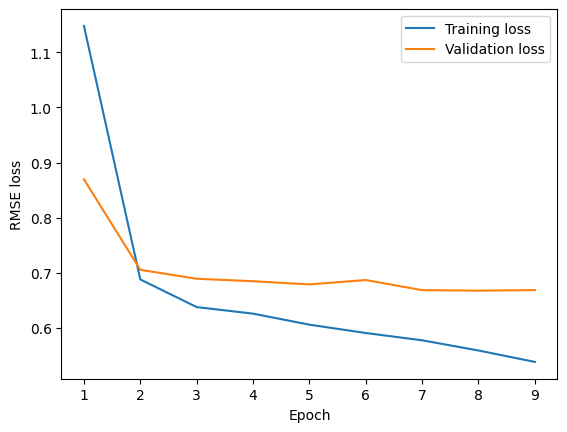

In [182]:
# extract Training loss and Validation loss from log_history
train_loss = [log['Training Loss'] for log in log_history[1]]
val_loss = [log['Validation Loss'] for log in log_history[1]]

# plot the training and validation loss, set title to "Batch size = 4, Learning rate = 4e-5"
plt.plot(np.arange(1, 10), train_loss, label='Training loss')
plt.plot(np.arange(1, 10), val_loss, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE loss')
plt.show()

### evaluate.py

In [ ]:
# TODO: Look at absolute error dist within each metric. 
#       If symmetric dists, summarise with mean - either in dist plots or in table.     
#       Identify the best hyperparameters using MAE or some other method... summed absolute error? 
#           - How well are the individual scores predicted?
#       Make a set of model-boxplots (with dots visible) for each metric.
#           - Which models perform best (i.e., generates predictable stories) on each metric?
#           - That is, are some model-stories harder to evaluate by the regression model?
#       Identify stories where the reg model was very wrong.

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [276]:
# load test_predictions.csv
df = pd.read_csv('../test_predictions_run32_test_torch.csv') # interestingly (hopefully not due to a bug) bs 32 and epoch 1 has way better results than bs 4 and epoch ~ 10
df

,Model,Story,Labels,Predictions
0,HINT,i woke up to a bright light on my bed. i woke ...,"[2.6666666666666665, 2.0, 2.0, 2.0, 1.33333333...","[3.272274971008301, 2.5711898803710938, 1.9557..."
1,Human,"She was ticked off, again. They knew it was a ...","[4.333333333333333, 3.0, 2.0, 3.33333333333333...","[3.4760005474090576, 2.4247145652770996, 2.242..."
2,GPT-2 (tag),I've always been superstitious about dying. It...,"[4.0, 2.6666666666666665, 3.6666666666666665, ...","[3.509080171585083, 2.49381160736084, 2.207363..."
3,GPT-2,'' There's a locked box in the ground... and i...,"[3.3333333333333335, 2.0, 2.3333333333333335, ...","[3.48150897026062, 2.535885810852051, 2.247283..."
4,XLNet,. We have been with you a long time. They have...,"[1.6666666666666667, 1.3333333333333333, 1.0, ...","[3.2900030612945557, 2.0582432746887207, 2.213..."
...,...,...,...,...
154,Human,"Hi Lucy. You don’t know me, but in ten years w...","[5.0, 3.0, 3.6666666666666665, 4.6666666666666...","[3.0074851512908936, 2.344653844833374, 2.0198..."
155,GPT-2 (tag),"My soulmate was born with golden skin, well-ke...","[3.6666666666666665, 3.0, 2.0, 3.6666666666666...","[3.1845552921295166, 2.3342506885528564, 2.168..."
156,HINT,we've been here for a while now. we've been he...,"[2.3333333333333335, 2.3333333333333335, 2.0, ...","[3.1723175048828125, 1.9824663400650024, 2.036..."
157,RoBERTa,As usual the cats were going through most of t...,"[3.3333333333333335, 1.0, 2.0, 2.3333333333333...","[3.4054501056671143, 2.4865241050720215, 2.298..."


In [163]:
def str_to_array(s):
    s = s.replace('[', '')
    s = s.replace(']', '')
    s = s.replace(' ', '')
    s = s.split(',')
    return np.array(s).astype(float)

In [277]:
# calculate absolute error
Errors = []
AErrors = []

for row in range(len(df)):
    
    predictions = df.loc[row, 'Predictions']
    labels = df.loc[row, 'Labels']

    predictions = str_to_array(predictions)
    labels = str_to_array(labels)

    Error = predictions - labels
    Errors.append(Error)
    AError = abs(predictions - labels)
    AErrors.append(AError)

df['Error'] = Errors
df['Absolute Error'] = AErrors

In [283]:
df

,Model,Story,Labels,Predictions,Error,Absolute Error
0,HINT,i woke up to a bright light on my bed. i woke ...,"[2.6666666666666665, 2.0, 2.0, 2.0, 1.33333333...","[3.272274971008301, 2.5711898803710938, 1.9557...","[0.6056083043416343, 0.5711898803710938, -0.04...","[0.6056083043416343, 0.5711898803710938, 0.044..."
1,Human,"She was ticked off, again. They knew it was a ...","[4.333333333333333, 3.0, 2.0, 3.33333333333333...","[3.4760005474090576, 2.4247145652770996, 2.242...","[-0.8573327859242754, -0.5752854347229004, 0.2...","[0.8573327859242754, 0.5752854347229004, 0.242..."
2,GPT-2 (tag),I've always been superstitious about dying. It...,"[4.0, 2.6666666666666665, 3.6666666666666665, ...","[3.509080171585083, 2.49381160736084, 2.207363...","[-0.490919828414917, -0.17285505930582667, -1....","[0.490919828414917, 0.17285505930582667, 1.459..."
3,GPT-2,'' There's a locked box in the ground... and i...,"[3.3333333333333335, 2.0, 2.3333333333333335, ...","[3.48150897026062, 2.535885810852051, 2.247283...","[0.14817563692728664, 0.5358858108520508, -0.0...","[0.14817563692728664, 0.5358858108520508, 0.08..."
4,XLNet,. We have been with you a long time. They have...,"[1.6666666666666667, 1.3333333333333333, 1.0, ...","[3.2900030612945557, 2.0582432746887207, 2.213...","[1.623336394627889, 0.7249099413553874, 1.2132...","[1.623336394627889, 0.7249099413553874, 1.2132..."
...,...,...,...,...,...,...
154,Human,"Hi Lucy. You don’t know me, but in ten years w...","[5.0, 3.0, 3.6666666666666665, 4.6666666666666...","[3.0074851512908936, 2.344653844833374, 2.0198...","[-1.9925148487091064, -0.655346155166626, -1.6...","[1.9925148487091064, 0.655346155166626, 1.6468..."
155,GPT-2 (tag),"My soulmate was born with golden skin, well-ke...","[3.6666666666666665, 3.0, 2.0, 3.6666666666666...","[3.1845552921295166, 2.3342506885528564, 2.168...","[-0.4821113745371499, -0.6657493114471436, 0.1...","[0.4821113745371499, 0.6657493114471436, 0.168..."
156,HINT,we've been here for a while now. we've been he...,"[2.3333333333333335, 2.3333333333333335, 2.0, ...","[3.1723175048828125, 1.9824663400650024, 2.036...","[0.838984171549479, -0.35086699326833104, 0.03...","[0.838984171549479, 0.35086699326833104, 0.036..."
157,RoBERTa,As usual the cats were going through most of t...,"[3.3333333333333335, 1.0, 2.0, 2.3333333333333...","[3.4054501056671143, 2.4865241050720215, 2.298...","[0.07211677233378078, 1.4865241050720215, 0.29...","[0.07211677233378078, 1.4865241050720215, 0.29..."


In [195]:
metrics = ['Coherence', 'Empathy', 'Surprise', 'Engagement', 'Complexity']

In [284]:
coherence_error = [error[0] for error in AErrors]
empathy_error = [error[1] for error in AErrors]
surprise_error = [error[2] for error in AErrors]
engagement_error = [error[3] for error in AErrors]
complexity_error = [error[4] for error in AErrors]
df['Coherence Error'] = coherence_error
df['Empathy Error'] = empathy_error
df['Surprise Error'] = surprise_error
df['Engagement Error'] = engagement_error
df['Complexity Error'] = complexity_error
error_list = [coherence_error, empathy_error, surprise_error, engagement_error, complexity_error]
df

,Model,Story,Labels,Predictions,Error,Absolute Error,Coherence Error,Empathy Error,Surprise Error,Engagement Error,Complexity Error
0,HINT,i woke up to a bright light on my bed. i woke ...,"[2.6666666666666665, 2.0, 2.0, 2.0, 1.33333333...","[3.272274971008301, 2.5711898803710938, 1.9557...","[0.6056083043416343, 0.5711898803710938, -0.04...","[0.6056083043416343, 0.5711898803710938, 0.044...",0.605608,0.571190,0.044286,0.666552,1.063823
1,Human,"She was ticked off, again. They knew it was a ...","[4.333333333333333, 3.0, 2.0, 3.33333333333333...","[3.4760005474090576, 2.4247145652770996, 2.242...","[-0.8573327859242754, -0.5752854347229004, 0.2...","[0.8573327859242754, 0.5752854347229004, 0.242...",0.857333,0.575285,0.242541,0.501381,0.624994
2,GPT-2 (tag),I've always been superstitious about dying. It...,"[4.0, 2.6666666666666665, 3.6666666666666665, ...","[3.509080171585083, 2.49381160736084, 2.207363...","[-0.490919828414917, -0.17285505930582667, -1....","[0.490919828414917, 0.17285505930582667, 1.459...",0.490920,0.172855,1.459303,0.839640,0.711277
3,GPT-2,'' There's a locked box in the ground... and i...,"[3.3333333333333335, 2.0, 2.3333333333333335, ...","[3.48150897026062, 2.535885810852051, 2.247283...","[0.14817563692728664, 0.5358858108520508, -0.0...","[0.14817563692728664, 0.5358858108520508, 0.08...",0.148176,0.535886,0.086050,0.433612,0.693830
4,XLNet,. We have been with you a long time. They have...,"[1.6666666666666667, 1.3333333333333333, 1.0, ...","[3.2900030612945557, 2.0582432746887207, 2.213...","[1.623336394627889, 0.7249099413553874, 1.2132...","[1.623336394627889, 0.7249099413553874, 1.2132...",1.623336,0.724910,1.213212,0.638780,0.448066
...,...,...,...,...,...,...,...,...,...,...,...
154,Human,"Hi Lucy. You don’t know me, but in ten years w...","[5.0, 3.0, 3.6666666666666665, 4.6666666666666...","[3.0074851512908936, 2.344653844833374, 2.0198...","[-1.9925148487091064, -0.655346155166626, -1.6...","[1.9925148487091064, 0.655346155166626, 1.6468...",1.992515,0.655346,1.646851,1.617460,1.066396
155,GPT-2 (tag),"My soulmate was born with golden skin, well-ke...","[3.6666666666666665, 3.0, 2.0, 3.6666666666666...","[3.1845552921295166, 2.3342506885528564, 2.168...","[-0.4821113745371499, -0.6657493114471436, 0.1...","[0.4821113745371499, 0.6657493114471436, 0.168...",0.482111,0.665749,0.168783,0.727635,1.162754
156,HINT,we've been here for a while now. we've been he...,"[2.3333333333333335, 2.3333333333333335, 2.0, ...","[3.1723175048828125, 1.9824663400650024, 2.036...","[0.838984171549479, -0.35086699326833104, 0.03...","[0.838984171549479, 0.35086699326833104, 0.036...",0.838984,0.350867,0.036144,0.651785,0.182068
157,RoBERTa,As usual the cats were going through most of t...,"[3.3333333333333335, 1.0, 2.0, 2.3333333333333...","[3.4054501056671143, 2.4865241050720215, 2.298...","[0.07211677233378078, 1.4865241050720215, 0.29...","[0.07211677233378078, 1.4865241050720215, 0.29...",0.072117,1.486524,0.298562,0.579151,0.010531


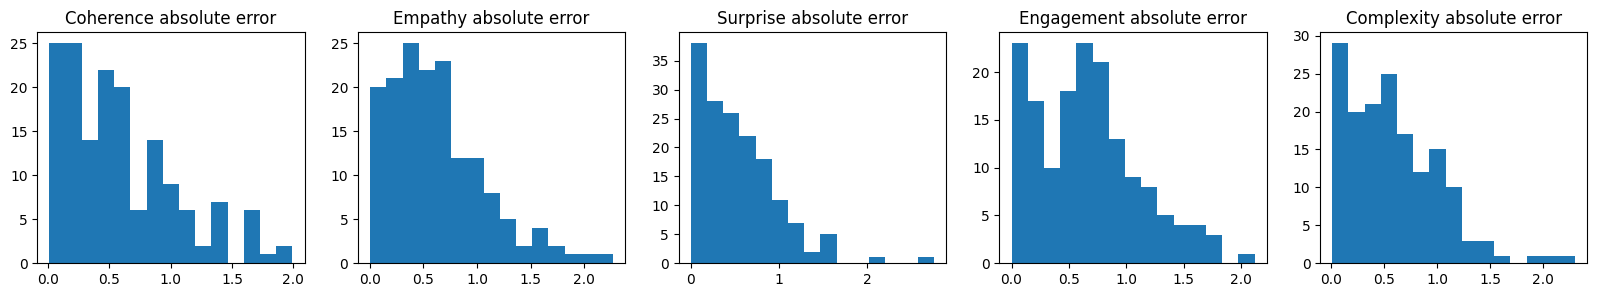

In [197]:
# plot histogram of each metric's error
fig, axs = plt.subplots(1, 5, figsize=(20, 3))
for i, ax in enumerate(axs):
    ax.hist(error_list[i], bins=15)
    ax.set_title(f'{metrics[i]} absolute error')

In [285]:
# calculate mean and summed absolute error for each metric
error_summary = {metric: {
                        'mean': np.mean(error_list[i]), 
                        'sum': np.sum(error_list[i])
                        } 
                          for i, metric in enumerate(metrics)
                }

In [286]:
error_summary

{'Coherence': {'mean': 0.5918828736311235, 'sum': 94.10937690734863},
 'Empathy': {'mean': 0.6256825983899195, 'sum': 99.48353314399719},
 'Surprise': {'mean': 0.5471642197303053, 'sum': 86.99911093711853},
 'Engagement': {'mean': 0.6637476830112609, 'sum': 105.53588159879047},
 'Complexity': {'mean': 0.5877840281532495, 'sum': 93.45766047636667}}

In [288]:
error_summary['overall'] = {'mean': round( np.mean([metric['mean'] for metric in error_summary.values()]) , 3), 
                            'sum': round( np.sum([metric['sum'] for metric in error_summary.values()]) , 3)}

# write error_summary to csv
error_summary_df = pd.DataFrame(error_summary).T
error_summary_df.to_csv('../absolute_error_summary_run32_test_torch.csv')

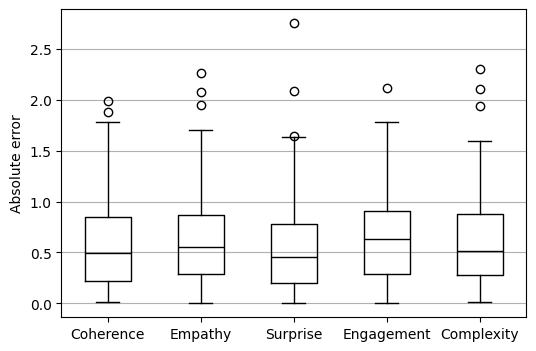

In [324]:
# plot boxplot of each metric's error in the same axis

fig, ax = plt.subplots(figsize=(6, 4))
ax.boxplot(error_list, medianprops=dict(color='black'))
ax.set_xticklabels(metrics)
ax.yaxis.grid(True)
ax.set_ylabel('Absolute error')
plt.show()

In [304]:
# find max absolute error
lists = df['Absolute Error'].apply(lambda x: x.tolist())
all_abs_errors = [item for sublist in lists for item in sublist]
max_abs_error = max(all_abs_errors)

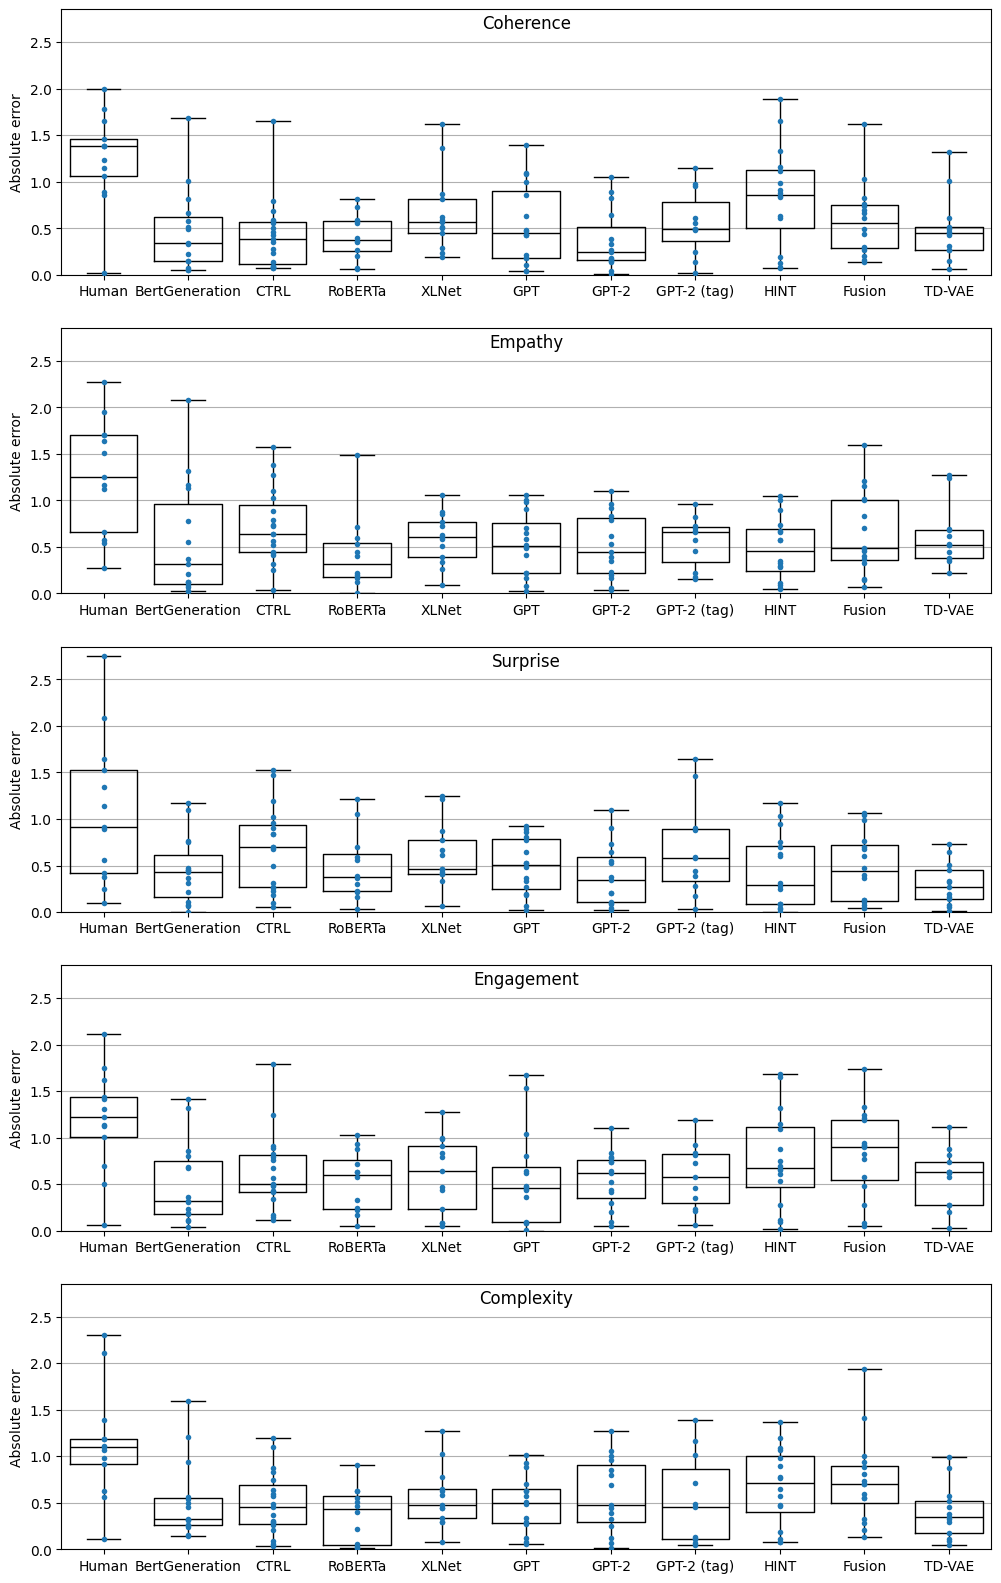

In [326]:
ags_models = ['Human', 'BertGeneration', 'CTRL', 'RoBERTa', 'XLNet', 'GPT', 'GPT-2', 'GPT-2 (tag)', 'HINT', 'Fusion', 'TD-VAE']
metric_errors = df.iloc[:, 6:].columns

# Create subplots for each metric
fig, axs = plt.subplots(len(metric_errors), 1, figsize=(12, 20))

for j, metric_error in enumerate(metric_errors):
    sns.stripplot(data=df, x='Model', y=metric_error, 
                  jitter=False, s=4, color='#1f77b4',
                  order=ags_models,
                  ax=axs[j])
    sns.boxplot(data=df, x='Model', y=metric_error, 
                fill=False, whis=(0,100), color='black', linewidth=1,
                order=ags_models,
                ax=axs[j])
    axs[j].set_xlabel('')
    axs[j].set_ylabel('Absolute error')
    axs[j].set_ylim(0, max_abs_error+0.1)
    axs[j].yaxis.grid(True)
    axs[j].set_title(f'{metric_error.split()[0]}', y=1.0, pad=-14)

plt.show()

TODO: 
- lav barplot der viser count af alle modeller i test data og/eller table
- lav boxplot i data_prep der viser scores i test data for hver model.